In [1213]:
%autosave 180

Autosaving every 180 seconds


In [21]:
import convex as cx
import requests
import time

In [34]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [633]:
def set_nlp(sentence):
    return nlp(sentence)

In [379]:
from hdt import HDTDocument
hdt_wd = HDTDocument("data/kb/wikidata2018_09_11.hdt")

In [1612]:
questions = [ 
    "Which actor voiced the Unicorn in The Last Unicorn?",
    "And Alan Arkin was behind...?",
    "And Alan Arkin be behind...? Why How when which was happy make fun",
    "Who is the composer of the soundtrack?",
    "So who performed the songs?",
    "Genre of this band's music?",
    "By the way, who was the director?"
            ]

q_test = str("Which actor voiced the Unicorn in The Last Unicorn? "+
    "And Alan Arkin was behind...? "+
    "And Alan Arkin be behind...? Why How when which was happy make fun. "+
    "Who is the composer of the soundtrack? "+
    "So who performed songs? "+
    "Genre of this band's music? "+
    "By the way, who was the director? ")

q_test_2 = "Who is the wife of Barack Obama?"

In [1613]:
q0_nlp = set_nlp(questions[0])
q0_nlp_test = set_nlp(q_test)
q0_nlp_test_2 = set_nlp(q_test_2)
q0_nlp

Which actor voiced the Unicorn in The Last Unicorn?

In [541]:
import re
def is_wd_entity(to_check):
    pattern = re.compile('^Q[0-9]*$')
    if pattern.match(to_check.strip()): return True
    else: return False

def is_wd_predicate(to_check):
    pattern = re.compile('^P[0-9]*$')
    if pattern.match(to_check.strip()): return True
    else: return False
    
def is_valide_wd_id(to_check):
    if is_wd_entity(to_check) or is_wd_predicate(to_check): return True
    else: return False

print(is_valide_wd_id("P8765"))

True


In [442]:
def get_wd_ids_online(name, is_predicate=False, top_k=3):
    name = name.split('(')[0]

    request_successfull = False
    entity_ids = ""
    while not request_successfull:
        try:
            if is_predicate:
                entity_ids = requests.get('https://www.wikidata.org/w/api.php?action=wbsearchentities&format=json&language=en&type=property&limit=' + str(top_k) + '&search='+name).json()
            else:
                entity_ids = requests.get('https://www.wikidata.org/w/api.php?action=wbsearchentities&format=json&language=en&limit=' + str(top_k) + '&search='+name).json()
            request_successfull = True
        except:
            time.sleep(5)
    results = entity_ids.get("search")
    if not results:
        return ""
    if not len(results):
        return ""
    res = []
    for result in results:
        res.append(result['id'])
    return res
get_wd_ids_online("voiced", is_predicate=False, top_k=1)

['Q7907375']

In [427]:
import warnings
warnings.filterwarnings('ignore')

# very computational
def get_most_similar(word, topn=5):
  word = nlp.vocab[str(word)]
  queries = [w for w in word.vocab if w.is_lower == word.is_lower and w.prob >= -15]
  by_similarity = sorted(queries, key=lambda w: word.similarity(w), reverse=True)
  return [(w.lower_,w.similarity(word)) for w in by_similarity[:topn+1] if w.lower_ != word.lower_]

get_most_similar("voiced", topn=3)

[('voicing', 0.7561705), ('voices', 0.6340212), ('voice', 0.5594842)]

In [1296]:
def get_wd_ids(word, top_k=3, limit=10):
    language = "en"
    word_formated = str("\""+word+"\""+"@"+language)
    to_remove = len("http://www.wikidata.org/entity/")
    t_name, card_name = hdt_wd.search_triples("", "http://schema.org/name", word_formated, limit=top_k)
    #print("names cardinality of \"" + word+"\": %i" % card_name)
    t_alt, card_alt = hdt_wd.search_triples("", 'http://www.w3.org/2004/02/skos/core#altLabel', word_formated, limit=top_k)
    #print("alternative names cardinality of \"" + word+"\": %i" % card_alt)
    
    return list(set(
        [t[0][to_remove:] for t in t_name if is_valide_wd_id(t[0][to_remove:])] + 
        [t[0][to_remove:] for t in t_alt if is_valide_wd_id(t[0][to_remove:])]
           ))[:limit]
    
get_wd_ids("The Last Unicorn", top_k=3, limit=10)

['Q16614390', 'Q30060419', 'Q176198', 'Q15628943']

In [1595]:
def get_wd_label(from_id):
    #print("from_id",from_id)
    if is_valide_wd_id(from_id):
        language = "en"
        id_url = "http://www.wikidata.org/entity/"+from_id
        t_name, card_name = hdt_wd.search_triples(id_url, "http://schema.org/name", "")
        name = [t[2].split('\"@en')[0].replace("\"", "") for t in t_name if "@"+language in t[2]]
        return name[0] if name else ''
    else:
        return ''
    
get_wd_label("P725")
#get_wd_label("Q20789322")

'voice actor'

In [1677]:
import matplotlib.pyplot as plt
%matplotlib inline

# Building colors from graph
def get_color(node_type):
    if node_type == "entity": return "violet"#"cornflowerblue"
    elif node_type == "predicate": return "yellow"
    else: return "red"

# Building labels for graph
def get_elements_from_graph(graph):
    node_names = nx.get_node_attributes(graph,"name")
    node_types = nx.get_node_attributes(graph,"type")
    colors = [get_color(node_types[n]) for n in node_names]
    return node_names, colors

# Plotting the graph
def plot_graph(graph, name, title="Graph"):
    fig = plt.figure(figsize=(14,14))
    ax = plt.subplot(111)
    ax.set_title(str("answer: "+title), fontsize=10)
    pos = nx.spring_layout(graph)
    labels, colors = get_elements_from_graph(graph)
    nx.draw(graph, pos, node_size=30, node_color=colors, font_size=10, font_weight='bold', with_labels=True, labels=labels)
    plt.tight_layout()
    plt.savefig(str(name)+".png", format="PNG", dpi = 300)
    plt.show()
    
#plot_graph(graph, "file_name_graph", "Graph_title")

{'P453': 1, 'P725': 1, 'P31': 1, 'P2868': 1, 'P1441': 1, 'P642': 1}


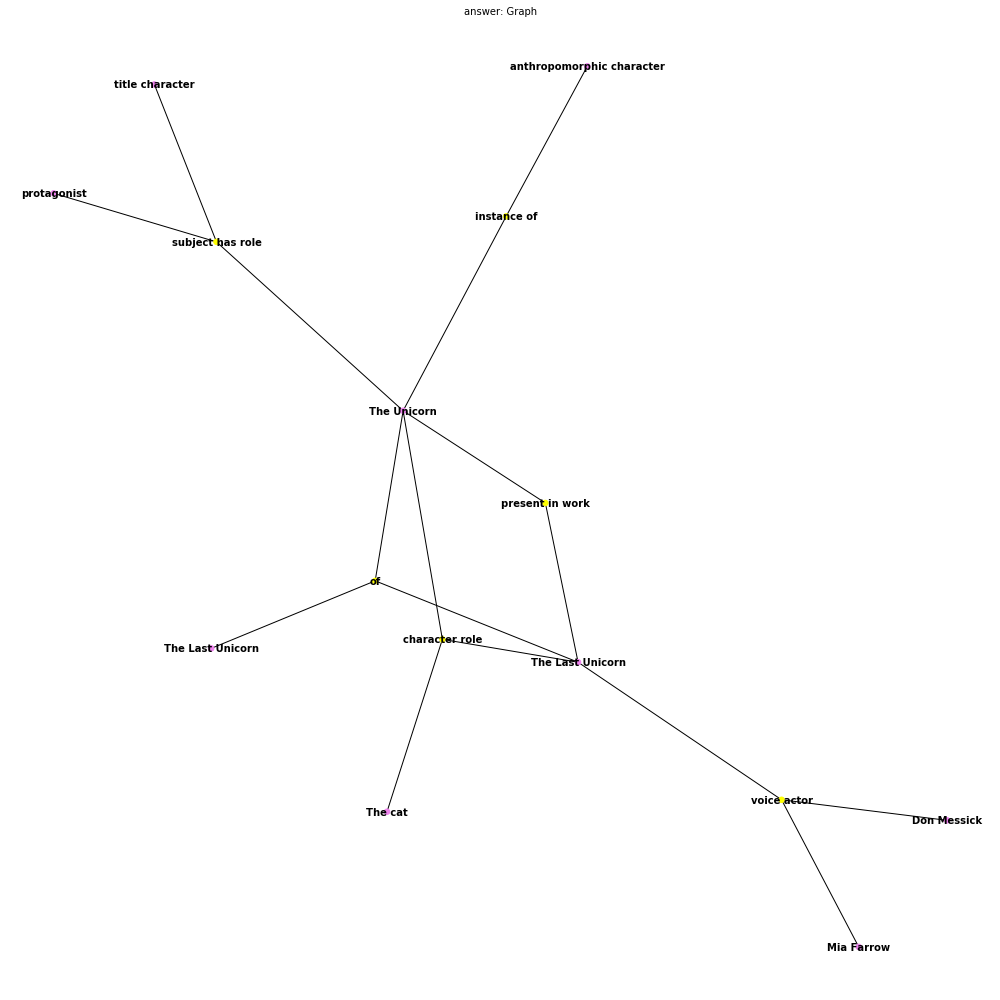

In [1703]:
import networkx as nx

def make_statements_graph(statements, indexing_predicates=True):
    graph = nx.Graph()
    turn=0
    predicate_nodes = {}

    for statement in statements:
        #print(statement)
        if not statement['entity']['id'] in graph:
            graph.add_node(statement['entity']['id'], name=get_wd_label(statement['entity']['id']), type='entity', turn=turn)
        if not statement['object']['id'] in graph:
            graph.add_node(statement['object']['id'], name=get_wd_label(statement['object']['id']), type='entity', turn=turn)

        # increment index of predicate or set it at 0
        if not statement['predicate']['id'] in predicate_nodes or not indexing_predicates:
            predicate_nodes_index = 1
            predicate_nodes[statement['predicate']['id']] = 1
        else:
            predicate_nodes[statement['predicate']['id']] += 1
            predicate_nodes_index = predicate_nodes[statement['predicate']['id']]

        # add the predicate node
        predicate_node_id = (statement['predicate']['id'])
        if indexing_predicates: predicate_node_id += "-" + str(predicate_nodes_index)
        
        graph.add_node(predicate_node_id, name=get_wd_label(statement['predicate']['id']), type='predicate', turn=turn)

        # add the two edges (entity->predicate->object)
        graph.add_edge(statement['entity']['id'], predicate_node_id)
        graph.add_edge(predicate_node_id, statement['object']['id'])
    
    return graph, predicate_nodes

test_graph = make_statements_graph(test_unduplicate_statements, indexing_predicates=False)
print(test_graph[1])
plot_graph(test_graph[0],"test")

In [443]:
def merge_lists(list_1, list_2):
    if len(list_1) == len(list_2):
        return [(list_1[i], list_2[i]) for i in range(0, len(list_1))]
    else:
        return "Error: lists are not the same lenght"

merge_lists([1,2,3],[4,5,6])

[(1, 4), (2, 5), (3, 6)]

In [1616]:
def get_themes(nlp_question, top_k=3):
    themes = []
    theme_complements = []
    
    noun_chunks = [chunk for chunk in nlp_question.noun_chunks]
    theme_ids = [get_wd_ids(chunk.text, top_k=top_k) for chunk in noun_chunks]

    for i, chunk in enumerate(theme_ids):
        if chunk: themes.append((noun_chunks[i], chunk))
        else: theme_complements.append(noun_chunks[i])
    
    return themes, theme_complements

q0_themes = get_themes(q0_nlp, top_k=3)
q0_themes_test = get_themes(q0_nlp_test)
q0_themes_test_2 = get_themes(q0_nlp_test_2)
q0_themes

([(The Last Unicorn, ['Q16614390', 'Q30060419', 'Q176198', 'Q15628943'])],
 [Which actor, the Unicorn])

In [1617]:
def get_predicates_online(nlp_sentence, top_k=3):
    predicates = [p for p in nlp_sentence if p.pos_ == "VERB" or p.pos_ == "AUX"]
    predicates_ids = [get_wd_ids_online(p.text, is_predicate=True, top_k=top_k) for p in predicates]
    return merge_lists(predicates, predicates_ids)

q0_predicates = get_predicates_online(q0_nlp, top_k=3)
q0_predicates_test_2 = get_predicates_online(q0_nlp_test_2, top_k=3)
q0_predicates

[(voiced, ['P725'])]

In [1618]:
def get_focused_parts(nlp_sentence, top_k=3):
    focused_parts = [t.head for t in nlp_sentence if t.tag_ == "WDT" or t.tag_ == "WP" or t.tag_ == "WP$" or t.tag_ == "WRB"] 
    focused_parts_ids = [get_wd_ids(p.text, top_k=top_k) for p in focused_parts]
    return merge_lists(focused_parts, focused_parts_ids)

q0_focused_parts = get_focused_parts(q0_nlp)
q0_focused_parts_test_2 = get_focused_parts(q0_nlp_test_2)
q0_focused_parts

[(actor, ['Q421946', 'P161', 'Q10798782', 'Q33999', 'Q4677712'])]

In [776]:
from itertools import chain
def extract_ids(to_extract):
    return [i for i in chain.from_iterable([id[1] for id in to_extract])]
#extract_ids([('name', ['id'])]) #q0_themes[0] #q0_focused_parts #q0_predicates
#extract_ids([("The Last Unicorn", ['Q16614390']),("Second Theme", ['Q12345'])])
extract_ids(q0_focused_parts)

['Q421946', 'P161', 'Q10798782', 'Q33999', 'Q4677712']

In [1399]:
def get_similarity_by_words(nlp_word_from, nlp_word_to):
    if not nlp_word_from or not nlp_word_to:
        return 0
    elif not nlp_word_from.vector_norm or not nlp_word_to.vector_norm:
        return 0
    else:
        return nlp_word_from.similarity(nlp_word_to)

get_similarity_by_words(get_nlp("character role"), get_nlp("voice actor"))

0.6516460644618532

In [1400]:
def get_similarity_by_ids(word_id_from, word_id_to):
    nlp_word_from = get_nlp(get_wd_label(word_id_from))
    nlp_word_to = get_nlp(get_wd_label(word_id_to))
    return get_similarity_by_words(nlp_word_from, nlp_word_to)

get_similarity_by_ids("P453", "P725")

0.6516460644618532

In [1393]:
def get_top_similar_statements(statements, from_token_id, similar_to_name, top_k=3, qualifier=False, statement_type="object"):
    highest_matching_similarity = -1
    top_statements = []
    nlp_name = get_nlp(similar_to_name)
    
    if get_wd_label(from_token_id):
        for statement in statements:
            if qualifier:
                if statement.get('qualifiers'):
                    for qualifier in statement['qualifiers']:
                        nlp_word_to = get_nlp(get_wd_label(qualifier[statement_type]['id']))
                        matching_similarity = get_similarity_by_words(nlp_name, nlp_word_to)
                        if highest_matching_similarity == -1 or matching_similarity > highest_matching_similarity:
                            highest_matching_similarity = matching_similarity
                            best_statement = statement
                            top_statements.append((highest_matching_similarity, best_statement))
            else:
                nlp_word_to = get_nlp(get_wd_label(statement[statement_type]['id']))
                matching_similarity = get_similarity_by_words(nlp_name, nlp_word_to)
                if highest_matching_similarity == -1 or matching_similarity > highest_matching_similarity:
                    highest_matching_similarity = matching_similarity
                    best_statement = statement
                    top_statements.append((highest_matching_similarity, best_statement))
            
    return sorted(top_statements, key=lambda x: x[0], reverse=True)[:top_k]

statements = cx.wd.get_all_statements_of_entity('Q176198')
top_similar_statements = get_top_similar_statements(statements, 'Q176198', 'voiced')
top_similar_statements[0]

(0.36831644893980314,
 {'entity': {'id': 'Q176198'},
  'predicate': {'id': 'P136'},
  'object': {'id': 'Q28968511'},
  'qualifiers': []})

In [1391]:
def get_best_similar_statements_by_word(from_token_ids, similar_to_name, top_k=3, qualifier=False, statement_type="object"):
    best_statements = []
    for token in from_token_ids:
        statements = cx.wd.get_all_statements_of_entity(token)
        best_statements += get_top_similar_statements(statements, token, similar_to_name, top_k=top_k, qualifier=qualifier, statement_type=statement_type)

    return sorted(best_statements, key=lambda x: x[0], reverse=True)[:top_k]

best_similar_statements = get_best_similar_statements_by_word(extract_ids(q0_themes[0]), 'voiced', top_k=3, qualifier=True, statement_type="qualifier_object")
best_similar_statements[0]

(0.3872851385988705,
 {'entity': {'id': 'Q30060419'},
  'predicate': {'id': 'P1441'},
  'object': {'id': 'Q176198'},
  'qualifiers': [{'qualifier_predicate': {'id': 'P2868'},
    'qualifier_object': {'id': 'Q215972'}},
   {'qualifier_predicate': {'id': 'P2868'},
    'qualifier_object': {'id': 'Q3246821'}}]})

In [1367]:
def get_statements_subjects_labels(statements):
    return [get_wd_label(t[1]['entity']['id']) for t in statements]
get_statements_subjects_labels(best_similar_statements)

['The Unicorn', 'The Last Unicorn', 'The Last Unicorn']

In [1368]:
def get_statements_predicates_labels(statements):
    return [get_wd_label(t[1]['predicate']['id']) for t in statements]
get_statements_predicates_labels(best_similar_statements)

['present in work', 'voice actor', 'voice actor']

In [1369]:
def get_statements_objects_labels(statements):
    return [get_wd_label(t[1]['object']['id']) for t in statements]
get_statements_objects_labels(best_similar_statements)

['The Last Unicorn', 'Don Messick', 'Christopher Lee']

In [1370]:
def get_statements_qualifier_predicates_labels(statements):
    return [get_wd_label(t[1]['qualifiers'][0]['qualifier_predicate']['id']) for t in statements]
get_statements_qualifier_predicates_labels(best_similar_statements)

['subject has role', 'character role', 'character role']

In [1371]:
def get_statements_qualifier_objects_labels(statements):
    return [get_wd_label(t[1]['qualifiers'][0]['qualifier_object']['id']) for t in statements]
get_statements_qualifier_objects_labels(best_similar_statements)

['protagonist', 'The cat', 'King Haggard']

In [1622]:
def cluster_extend_by_words(cluster_root_ids, extending_words, top_k=3):
    cluster = []
    
    for name in extending_words:
        cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=True, statement_type="qualifier_predicate")
        cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=True, statement_type="qualifier_object")
        cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=False, statement_type="predicate")
        cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=False, statement_type="object")
        
    return cluster
    
test_cluster = cluster_extend_by_words(extract_ids(q0_themes[0]), ['voiced'], top_k=2)
test_cluster_test_2 = cluster_extend_by_words(extract_ids(q0_themes_test_2[0]), ['birth'], top_k=2)
test_cluster[0]

(0.4414132775507227,
 {'entity': {'id': 'Q176198'},
  'predicate': {'id': 'P725'},
  'object': {'id': 'Q202725'},
  'qualifiers': [{'qualifier_predicate': {'id': 'P453'},
    'qualifier_object': {'id': 'Q30060419'}}]})

In [1623]:
# sorts by the similarity value of statements[0]
def sort_statements_by_similarity(statements):
    return [s for s in sorted(statements, key=lambda x: x[0], reverse=True)]

test_sorted_statements = sort_statements_by_similarity(test_cluster)
test_sorted_statements_test_2 = sort_statements_by_similarity(test_cluster_test_2)
test_sorted_statements[0]

(0.5974342416487763,
 {'entity': {'id': 'Q176198'},
  'predicate': {'id': 'P725'},
  'object': {'id': 'Q202725'},
  'qualifiers': [{'qualifier_predicate': {'id': 'P453'},
    'qualifier_object': {'id': 'Q30060419'}}]})

In [1626]:
from copy import copy

# appends spo from qualifiers, removes qualifier tags, and removes similarity scores
def statements_flatter(statements):
    best_statements_to_graph = []
    for statement in statements:
        tmp_statement = copy(statement)
        if tmp_statement.get('qualifiers'):
            #print("statement", statement)
            for q in tmp_statement['qualifiers']:
                qualifier_statement = {'entity': {'id': tmp_statement['entity']['id']}}
                qualifier_statement['predicate'] = {'id': q['qualifier_predicate']['id']}
                qualifier_statement['object'] = {'id': q['qualifier_object']['id']}
                best_statements_to_graph.append(qualifier_statement)
            del(tmp_statement['qualifiers'])
        else: 
            #print("tmp_statement", tmp_statement)
            if ('qualifiers' in tmp_statement): del(tmp_statement['qualifiers'])
        if tmp_statement not in best_statements_to_graph:
            #print("best_statements_to_graph", tmp_statement)
            best_statements_to_graph.append(tmp_statement)
    return best_statements_to_graph

test_flatten_statements = statements_flatter([s[1] for s in test_sorted_statements])
#test_flatten_statements_test_2 = statements_flatter([s[1] for s in test_sorted_statements_test_2])
test_flatten_statements[0]
#test_flatten_statements_test_2

{'entity': {'id': 'Q176198'},
 'predicate': {'id': 'P453'},
 'object': {'id': 'Q30060419'}}

In [1375]:
# remove duplicates from statements
def unduplicate_statements(statements):
    filtered_statements = []
    [filtered_statements.append(s) for s in statements if s not in [e for e in filtered_statements]]
    return filtered_statements

test_unduplicate_statements = unduplicate_statements(test_flatten_statements)
print(len(test_flatten_statements))
print(len(test_unduplicate_statements))
test_unduplicate_statements[0]

15
10


{'entity': {'id': 'Q176198'},
 'predicate': {'id': 'P453'},
 'object': {'id': 'Q30060419'}}

{'P453': 2, 'P725': 2, 'P31': 1, 'P2868': 2, 'P1441': 1, 'P642': 2}


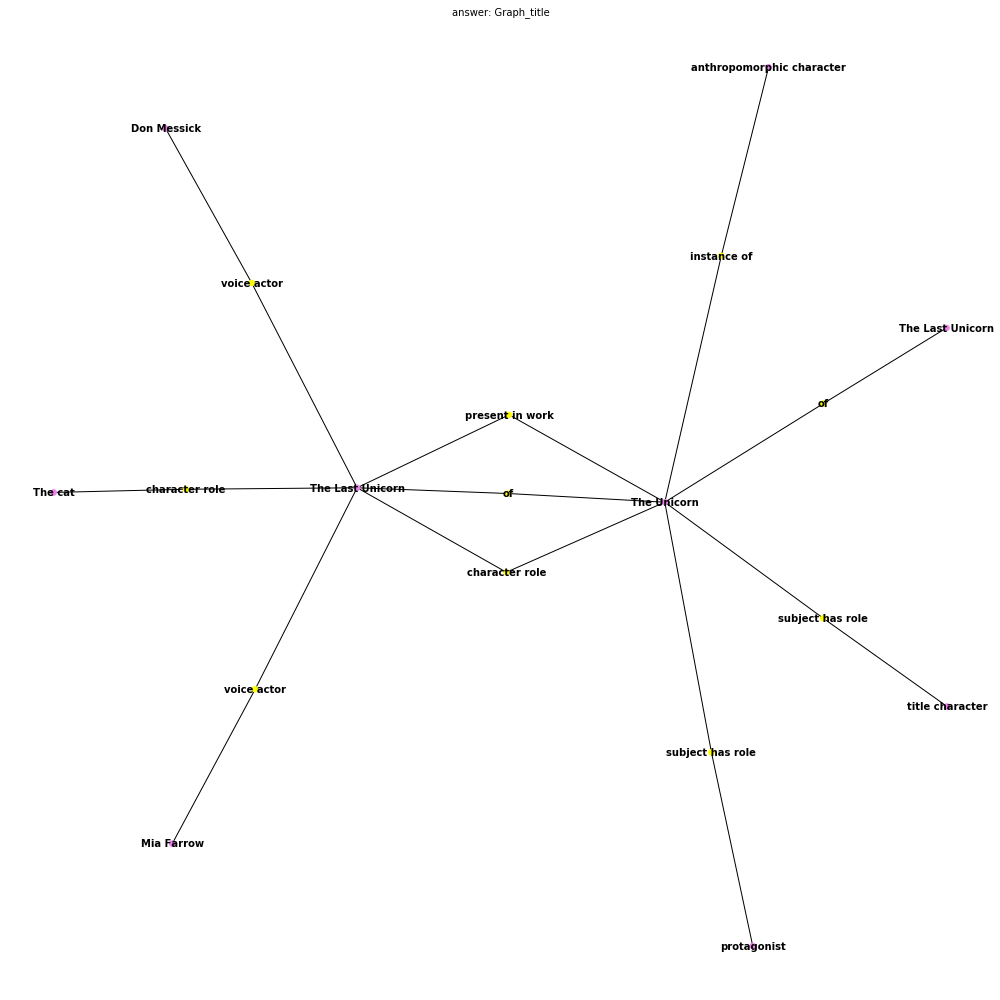

In [1376]:
test_graph = make_statements_graph(test_unduplicate_statements)
print(test_graph[1])
plot_graph(test_graph[0], "file_name_graph", "Graph_title")

In [1663]:
def get_statements_by_id(statements, from_token_id, to_id, qualifier=False, statement_type="predicate"):
    id_statements = []
    if cx.wd.wikidata_id_to_label(from_token_id):
        for statement in statements:
            if qualifier:
                if statement.get('qualifiers'):
                    for s in statement['qualifiers']:
                        if to_id == s[statement_type]['id']:
                            id_statements.append(statement)
            else:
                if to_id == statement[statement_type]['id']:
                    id_statements.append(statement)
    
    return id_statements

#statements_test = cx.wd.get_all_statements_of_entity('Q176198')
#id_statements_test = get_statements_by_id(statements_test, 'Q176198', 'P725')
#id_statements_test[0]

#get_statements_by_id(root_statements, cluster_root_id, predicate_id, qualifier=False, statement_type="predicate")
#statements_test = cx.wd.get_all_statements_of_entity('Q176198')
#id_statements_test = get_statements_by_id(statements_test, 'Q176198', 'P725')
#id_statements_test[0]

In [1670]:
# parameters
# cluster_root_ids: ['Qcode']
# predicates_ids: ['Pcode']
def cluster_extend_by_predicates_ids(cluster_root_ids, predicates_ids):
    cluster = []
    
    for cluster_root_id in cluster_root_ids:
        root_statements = cx.wd.get_all_statements_of_entity(cluster_root_id)
        #print("root_statements", root_statements)
        for predicate_id in predicates_ids:
            cluster += get_statements_by_id(root_statements, cluster_root_id, predicate_id, qualifier=True, statement_type="qualifier_predicate")
            cluster += get_statements_by_id(root_statements, cluster_root_id, predicate_id, qualifier=False, statement_type="predicate")

    return cluster
    
#test_predicate_clusters = cluster_extend_by_predicates_ids(extract_ids(q0_themes[0]), extract_ids(q0_predicates))
#print(len(test_predicate_clusters))
#test_predicate_clusters[0]

test_predicate_clusters_test_2 = cluster_extend_by_predicates_ids(extract_ids(q0_themes_test_2[0]), extract_ids(q0_predicates_test_2))
print(len(test_predicate_clusters_test_2))
test_predicate_clusters_test_2[-1]

11


{'entity': {'id': 'Q76'},
 'predicate': {'id': 'P19'},
 'object': {'id': 'Q6366688'},
 'qualifiers': [{'qualifier_predicate': {'id': 'P131'},
   'qualifier_object': {'id': 'Q782'}}]}

{'P453': 14, 'P725': 13, 'P31': 3, 'P2868': 2, 'P1441': 1, 'P642': 2, 'P136': 3, 'P58': 1, 'P162': 1, 'P361': 1, 'P175': 2, 'P1040': 1, 'P21': 1, 'P1340': 1, 'P646': 2}


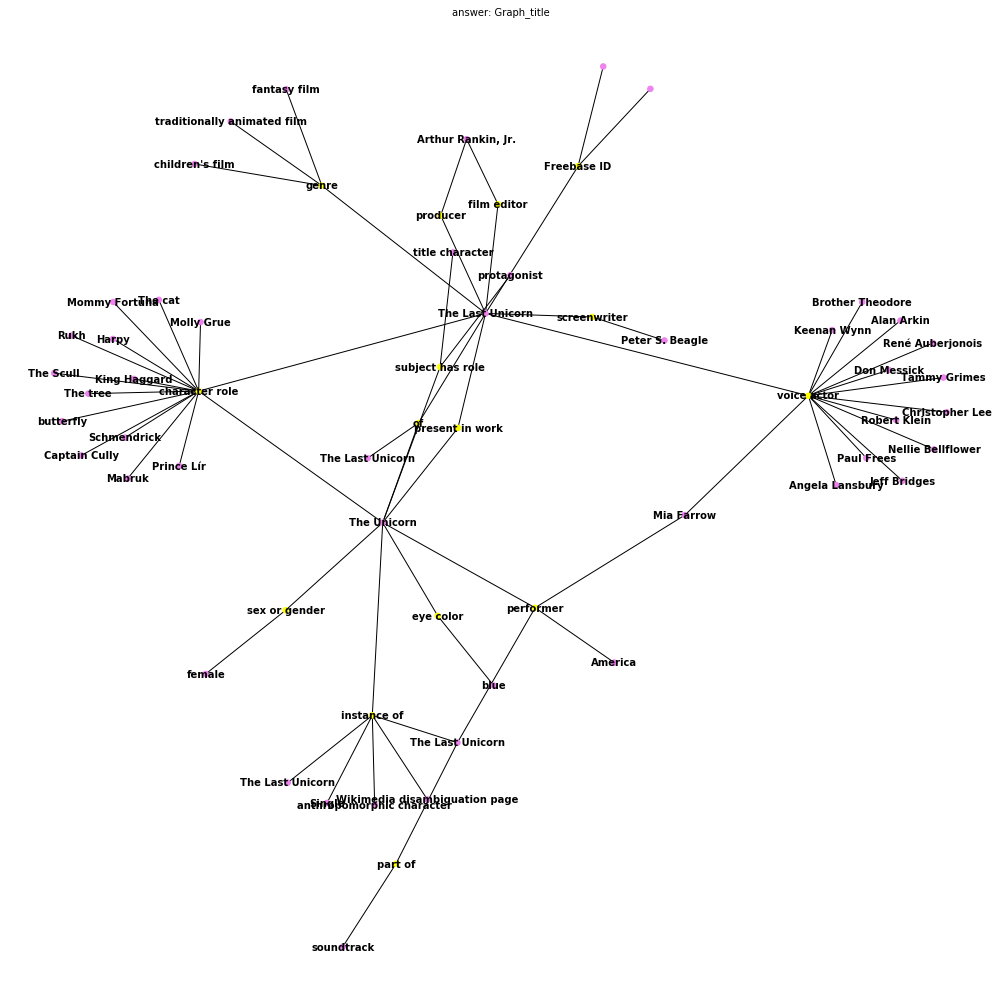

In [1685]:
# parameter
# question: nlp_string
def build_graph(nlp, themes, predicates, deep_k=50):
    init_clusters = cluster_extend_by_words(extract_ids(themes[0]), [p[0].text for p in predicates], top_k=deep_k)
    init_sorted_statements = sort_statements_by_similarity(init_clusters)
    init_flatten_statements = statements_flatter([s[1] for s in init_sorted_statements])
    
    predicate_ids_clusters = cluster_extend_by_predicates_ids(extract_ids(themes[0]), extract_ids(predicates))
    predicate_ids_flatten_statements = statements_flatter(predicate_ids_clusters)
    clusters = init_flatten_statements+predicate_ids_flatten_statements
    filtered_statements = unduplicate_statements(clusters)
    
    graph = make_statements_graph(filtered_statements)
    
    #print("clusters:", len(clusters))
    #print("filtered_statements:", len(filtered_statements))
    return graph

#q0_test = questions[0]
q0_test = "Which actor voiced the Unicorn in The Last Unicorn?"
q0_nlp_test = set_nlp(q0_test)
q0_themes_test = get_themes(q0_nlp_test, top_k=3)
q0_predicates_test = get_predicates_online(q0_nlp_test, top_k=3)
q0_focused_parts_test = get_focused_parts(q0_nlp_test)
graph, predicates_dict = build_graph(q0_nlp_test, q0_themes_test, q0_predicates_test)
print(predicates_dict)
plot_graph(graph, "file_name_graph", "Graph_title")

In [1380]:
# check the graph for complements
# parameters
# name: string
def find_name_in_graph(graph, name):
    return [x for x,y in graph.nodes(data=True) if y['name'].lower() == name.lower()]

#[find_name_in_graph(c.text) for c in q0_themes[1]]
find_name_in_graph(graph, "the unicorn")

['Q30060419']

In [1381]:
# TODO: clean the complements by removing stopwords etc.
def find_theme_complement(graph, themes):
    return [i for i in chain.from_iterable(
        [id for id in [c for c in [find_name_in_graph(graph, t.text) for t in themes[1]] if c]])]

find_theme_complement(graph, q_themes_test)
#[i for i in chain.from_iterable([id for id in check_theme_complement(graph, q0_themes)])]

['Q30060419']

In [1434]:
def find_paths_in_graph(graph, node_start, node_end):
    return [p for p in nx.all_simple_paths(graph, source=node_start, target=node_end)]
        
test_paths = find_paths_in_graph(graph, "Q176198", "Q202725")
test_paths

[['Q176198', 'P453-1', 'Q30060419', 'P175-2', 'Q202725'],
 ['Q176198', 'P725-1', 'Q202725'],
 ['Q176198', 'P1441-1', 'Q30060419', 'P175-2', 'Q202725'],
 ['Q176198', 'P642-1', 'Q30060419', 'P175-2', 'Q202725']]

In [1383]:
def is_id_in_graph(graph, node_id):
    return graph.has_node(node_id)
is_id_in_graph(graph, "Q176198")

True

In [1384]:
def is_name_in_graph(graph, node_name):
    return find_name_in_graph(graph, node_name) != []
is_name_in_graph(graph, "the Unicorn")

True

In [1385]:
def find_paths_for_themes(graph, themes):
    themes_ids = [t for t in  extract_ids(themes[0])]
    complements_ids = find_theme_complement(graph, themes)
    paths = []
    for t_id in themes_ids:
        if is_id_in_graph(graph, t_id):
            for c_id in complements_ids:
                if is_id_in_graph(graph, c_id):
                    path = find_paths_in_graph(graph, t_id, c_id)
                    if path:
                        paths.append(path)
    paths = [i for i in chain.from_iterable(
        [id for id in paths])]
    
    return paths
find_paths_for_themes(graph, q_themes_test)
find_paths_for_themes(graph, q0_themes)

[['Q176198', 'P453-1', 'Q30060419'],
 ['Q176198', 'P725-1', 'Q202725', 'P175-2', 'Q30060419'],
 ['Q176198', 'P1441-1', 'Q30060419'],
 ['Q176198', 'P642-1', 'Q30060419']]

In [1524]:
def get_node_predicates_from_path(paths):
    predicates = []
    for p in paths:
        [predicates.append(i[:i.find("-")]) for i in p if is_wd_predicate(i[:i.find("-")]) and i[:i.find("-")] not in predicates]
    return predicates

test_node_predicates = get_node_predicates_from_path(test_paths)
test_node_predicates

['P453', 'P175', 'P725', 'P1441', 'P642']

In [1525]:
def get_node_predicate_similarity_from_path(paths, predicates):
    path_predicates = get_node_predicates_from_path(paths)
    return sorted([(pp, get_similarity_by_ids(p2, pp)) for p in predicates for p2 in p[1] for pp in path_predicates], key=lambda x: x[-1], reverse=True)

test_node_pedicate_similarities = get_node_predicate_similarity_from_path(test_paths, q0_predicates)
test_node_pedicate_similarities

[('P725', 1.0),
 ('P453', 0.6516460644618532),
 ('P175', 0.5508198537586991),
 ('P1441', 0.34966764303274056),
 ('P642', 0.2361562242692872)]

In [1571]:
# TODO: make the predicate search go further in the path list for the !i%2
def find_anwser_from_graph(graph, q_nlp, themes, predicates):
    initial_paths = find_paths_for_themes(graph, themes)
    predicate_id_similarities = get_node_predicate_similarity_from_path(initial_paths, predicates)
    best_path = [p for p in initial_paths if predicate_id_similarities[0][0] == p[1][:p[1].find("-")]]
    path_answer = get_wd_label(best_path[0][2]) if best_path else []
    
    return path_answer if path_answer else ''

find_anwser_from_graph(graph, q0_nlp, q0_themes, q0_predicates)

'Mia Farrow'

In [1683]:
def answer_initial_question(question):
    q_nlp = set_nlp(question)
    q_themes = get_themes(q_nlp, top_k=3)
    q_predicates = get_predicates_online(q_nlp, top_k=3)
    q_focused_parts = get_focused_parts(q_nlp)
    graph, predicates_dict = build_graph(q_nlp, q_themes, q_predicates)
    #print(predicates_dict)
    plot_graph(graph, "main_graph", "Main_graph_title")
    print(find_anwser_from_graph(graph, q0_nlp, q0_themes, q0_predicates))

#answer_initial_question("Which actor voiced the Unicorn in The Last Unicorn?")
#answer_initial_question("Who is the author of Le Petit Prince?")
#answer_initial_question("Who made the soundtrack of the The Last Unicorn movie?")
#answer_initial_question("When was produced the first Matrix movie?")
#answer_initial_question("Who is the president of the United States?")
#answer_initial_question("Who is the wife of Barack Obama?")

In [1575]:
subgraphs = [graph.subgraph(c) for c in nx.connected_components(graph)]
len(subgraphs[0].nodes)

85

In [1576]:
def search_focused_part(graph):
    return 0

search_focused_part(graph)

0

In [1119]:
for path in nx.all_simple_paths(graph, source="Q176198", target="Q202725"):
    print(path)

['Q176198', 'P453-1', 'Q30060419', 'P175-2', 'Q202725']
['Q176198', 'P725-1', 'Q202725']
['Q176198', 'P1441-1', 'Q30060419', 'P175-2', 'Q202725']
['Q176198', 'P642-1', 'Q30060419', 'P175-2', 'Q202725']


In [1120]:
nx.shortest_path(graph, source="Q176198", target="Q202725")

['Q176198', 'P725-1', 'Q202725']

In [1116]:
[y['name'] for x,y in graph.nodes(data=True) if y['name'].lower() == "The Unicorn".lower()]

['The Unicorn']

In [1029]:
for complement in q0_themes[1]:
    print(complement)
    for e in complement:
        print(e, e.pos_, e.tag_, e.dep_, e.head)

print("\n")
for e in q0_nlp:
    print(e, e.pos_, e.tag_, e.dep_, e.head)

Which actor
Which DET WDT det actor
actor NOUN NN nsubj voiced
the Unicorn
the DET DT det Unicorn
Unicorn PROPN NNP dobj voiced


Which DET WDT det actor
actor NOUN NN nsubj voiced
voiced VERB VBD ROOT voiced
the DET DT det Unicorn
Unicorn PROPN NNP dobj voiced
in ADP IN prep voiced
The DET DT det Unicorn
Last ADJ JJ compound Unicorn
Unicorn PROPN NNP pobj in
? PUNCT . punct voiced


In [1574]:
list(nx.dfs_labeled_edges(graph, source=get_themes(question_0_nlp, top_k=3)[0][0][1][0], depth_limit=4))[0]

('Q16614390', 'Q16614390', 'forward')

In [951]:
get_themes(question_0_nlp, top_k=3)[0][0][1][0]

'Q16614390'